In [6]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
random.seed(42)

### temp

In [7]:
def split_Xy(data, case):
    """
    Split data into X and y for specific cases
    """
    if case == 1:
        # For stroke dataset
        target = 'stroke'
    else:
        # For heart failure dataset
        target = 'HeartDisease'

    data_y = data[target]
    data_X = data.drop(target, axis=1) 
    print(data_X.shape, data_y.shape)
    return data_X, data_y

def runSVM(data_X, data_y, test_X, case):
    
    if case == 1:
        # param_grid = {'svc__C': [0.1, 10], 'svc__gamma': [0.1, 10]}
        # pipeline = make_pipeline(SVC(kernel='linear', random_state=42))
        # grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
        # grid_search.fit(data_X, data_y)
        # best_params = grid_search.best_params_
        # print("Best parameters:", best_params)
        # best_C = best_params['svc__C']
        # best_gamma = best_params['svc__gamma']
        # svm_classifier = SVC(kernel='linear', random_state=42, C=best_C, gamma=best_gamma, class_weight={0: 0.05, 1: 0.95})
        svm_classifier = SVC(kernel='linear', random_state=42, class_weight={0: 0.05, 1: 0.95})
    else:
        svm_classifier = SVC(kernel='linear', random_state=42, class_weight=None)
    
    svm_classifier.fit(data_X, data_y)

    return svm_classifier.predict(test_X)

def model_evaluation(true, prediction, label):
    """
    Output evaluation metrics and plot the ROC curve
    """
    accuracy = accuracy_score(true, prediction)
    f1 = f1_score(true, prediction)
    conf_matrix = confusion_matrix(true, prediction)
    precision = precision_score(true, prediction)
    recall = recall_score(true, prediction)
    print(f"Accuracy score: {accuracy}")
    print(f"F1 score: {f1}")
    print(f"Confusion Matrix: \n{conf_matrix}")
    print(f"Precision: {precision} and Recall: {recall}")
    # Calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, _ = roc_curve(true, prediction)

    # Calculate the area under the curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {label}')
    plt.legend(loc='lower right')
    plt.show()
    return accuracy, f1, precision, recall, roc_auc

def bias_evaluation(preds, sens, labels, type):
    # stat_parity = P(Pred = 1 ∣ Sen = 1) - P(Pred = 1 ∣ Sen = 0)

    # Calculate the condition probability when accounting for empty array
    if len(preds[sens == 0]):
        preds_1_sens_0 = np.mean(preds[sens == 0])
    else:
        preds_1_sens_0 = 0

    if len(preds[sens == 1]):
        preds_1_sens_1 = np.mean(preds[sens == 1])
    else:
        preds_1_sens_1 = 0
    
    stat_parity = abs(preds_1_sens_1 - preds_1_sens_0)
    print(f"{type} Statistical Parity: {stat_parity}")

    # Calculate P(Pred = 0 | Sen = 1, Label = 1) minority while account for empty arrays
    if len(preds[(sens == 1) & (labels == 1)]):
        pred_1_sen_1_label_1 = np.mean(preds[(sens == 1) & (labels == 1)])
    else:
        pred_1_sen_1_label_1 = 0

    # Calculate P(Pred = 1 | Sen = 0, Label = 1) while account for empty arrays
    if len(preds[(sens == 0) & (labels == 1)]):
        pred_1_sen_0_label_1 = np.mean(preds[(sens == 0) & (labels == 1)])
    else:
        pred_1_sen_0_label_1 = 0
    
    equal_op = abs(pred_1_sen_1_label_1 - pred_1_sen_0_label_1)
    print(f"{type} Equal Opportunity: {equal_op}")

    return stat_parity, equal_op 

### Case 1: Base Case

In [11]:
stroke_base_train = pd.read_csv('data/train_test_data/base_case_stroke_train.csv')
stroke_base_test = pd.read_csv('data/train_test_data/base_case_stroke_test.csv')

stroke_train_X, stroke_train_y = split_Xy(stroke_base_train, 1)
stroke_test_X, stroke_test_y = split_Xy(stroke_base_test, 1)

heart_base_train = pd.read_csv('data/train_test_data/base_case_heart_train.csv')
heart_base_test = pd.read_csv('data/train_test_data/base_case_heart_test.csv')

heart_train_X, heart_train_y = split_Xy(heart_base_train, 2)
heart_test_X, heart_test_y = split_Xy(heart_base_test, 2)

(3576, 11) (3576,)
(1533, 11) (1533,)
(642, 11) (642,)
(276, 11) (276,)


Accuracy score: 0.5114155251141552
F1 score: 0.14789533560864618
Confusion Matrix: 
[[719 725]
 [ 24  65]]
Precision: 0.08227848101265822 and Recall: 0.7303370786516854


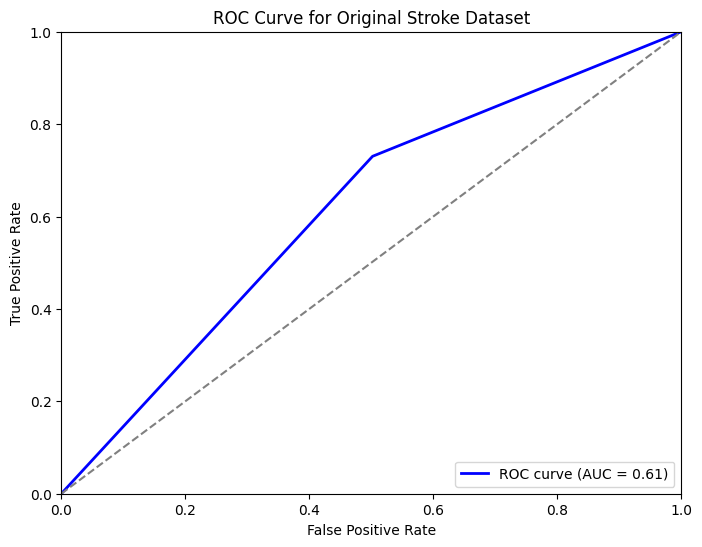

Gender Statistical Parity: 0.038037004405286345
Gender Equal Opportunity: -0.12653061224489803
Age Statistical Parity: 0.4455118276421989
Age Equal Opportunity: 0.35


In [36]:
stroke_yhat = runSVM(stroke_train_X, stroke_train_y, stroke_test_X, 1)
base_stroke_acc, base_stroke_f1, base_stroke_precision, base_stroke_recall, base_stroke_roc = model_evaluation(stroke_test_y, stroke_yhat, 'Original Stroke Dataset')
base_stroke_gen_stat_par, base_stroke_gen_eq_op = bias_evaluation(stroke_yhat, stroke_test_X['gender'], stroke_test_y, 'Gender')
base_stroke_age_stat_par, base_stroke_age_eq_op = bias_evaluation(stroke_yhat, stroke_test_X['age'], stroke_test_y, 'Age')

Accuracy score: 0.8586956521739131
F1 score: 0.8792569659442725
Confusion Matrix: 
[[ 95  17]
 [ 22 142]]
Precision: 0.8930817610062893 and Recall: 0.8658536585365854


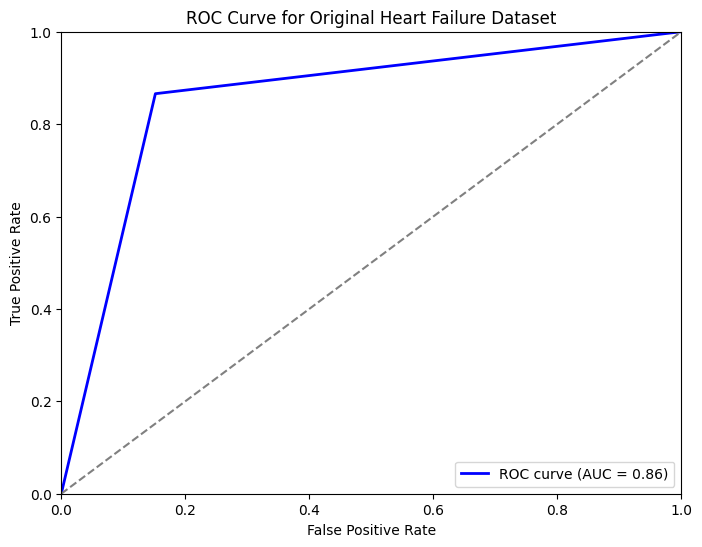

Gender Statistical Parity: 0.3782608695652174
Gender Equal Opportunity: 0.2459893048128342
Age Statistical Parity: 0.15837723919915703
Age Equal Opportunity: 0.15171564856131714


In [56]:
heart_yhat = runSVM(heart_train_X, heart_train_y, heart_test_X, 0)
base_heart_acc, base_heart_f1, base_heart_precision, base_heart_recall, base_heart_roc = model_evaluation(heart_test_y, heart_yhat, 'Original Heart Failure Dataset')
base_heart_gen_stat_par, base_heart_gen_eq_op = bias_evaluation(heart_yhat, heart_test_X['Sex'], heart_test_y, 'Gender')
base_heart_age_stat_par, base_heart_age_eq_op = bias_evaluation(heart_yhat, heart_test_X['Age'], heart_test_y, 'Age')

### Case 2: Remove protected classes variables

In [13]:
no_prot_stroke_train = pd.read_csv('data/train_test_data/no_prot_class_stroke_train.csv')
no_prot_stroke_test = pd.read_csv('data/train_test_data/no_prot_class_stroke_test.csv')

np_stroke_train_X, np_stroke_train_y = split_Xy(no_prot_stroke_train, 1)
np_stroke_test_X, np_stroke_test_y = split_Xy(no_prot_stroke_test, 1)

no_prot_heart_train = pd.read_csv('data/train_test_data/no_prot_class_heart_train.csv')
no_prot_heart_test = pd.read_csv('data/train_test_data/no_prot_class_heart_test.csv')

np_heart_train_X, np_heart_train_y = split_Xy(no_prot_heart_train, 2)
np_heart_test_X, np_heart_test_y = split_Xy(no_prot_heart_test, 2)

(3576, 9) (3576,)
(1533, 9) (1533,)
(642, 9) (642,)
(276, 9) (276,)


Accuracy score: 0.487279843444227
F1 score: 0.12276785714285715
Confusion Matrix: 
[[692 752]
 [ 34  55]]
Precision: 0.06815365551425032 and Recall: 0.6179775280898876


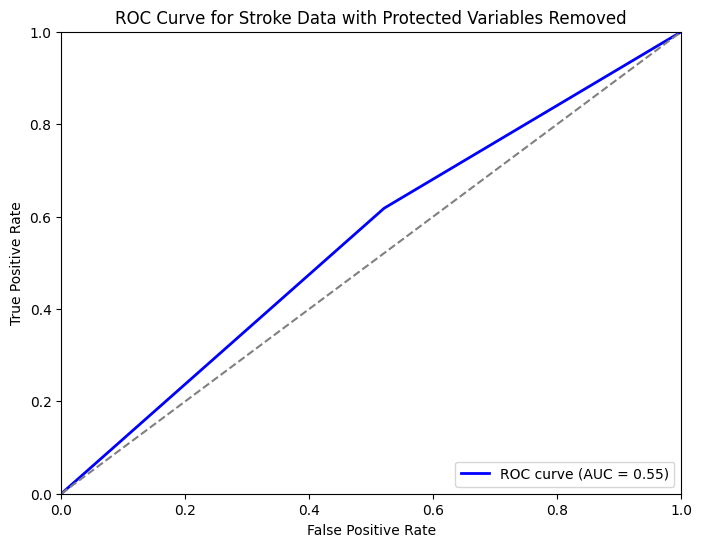

Gender Statistical Parity: 0.021642290748898785
Gender Equal Opportunity: -0.1489795918367347
Age Statistical Parity: 0.1832663287502425
Age Equal Opportunity: 0.01904761904761909


In [37]:
np_stroke_yhat = runSVM(np_stroke_train_X, np_stroke_train_y, np_stroke_test_X, 1)
np_stroke_acc, np_stroke_f1, np_stroke_precision, np_stroke_recall, np_stroke_roc = model_evaluation(np_stroke_test_y, np_stroke_yhat, 'Stroke Data with Protected Variables Removed')
np_stroke_gen_stat_par, np_stroke_gen_eq_op = bias_evaluation(np_stroke_yhat, stroke_test_X['gender'], np_stroke_test_y, 'Gender')
np_stroke_age_stat_par, np_stroke_age_eq_op = bias_evaluation(np_stroke_yhat, stroke_test_X['age'], np_stroke_test_y, 'Age')

Accuracy score: 0.8514492753623188
F1 score: 0.8738461538461538
Confusion Matrix: 
[[ 93  19]
 [ 22 142]]
Precision: 0.8819875776397516 and Recall: 0.8658536585365854


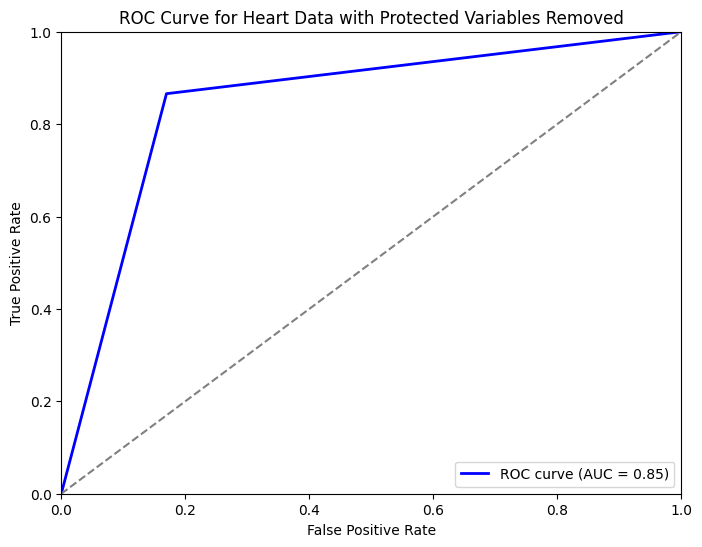

Gender Statistical Parity: 0.25652173913043486
Gender Equal Opportunity: 0.051099227569815775
Age Statistical Parity: 0.1429926238145417
Age Equal Opportunity: 0.10124634559162948


In [55]:
np_heart_yhat = runSVM(np_heart_train_X, np_heart_train_y, np_heart_test_X, 0)
np_heart_acc, np_heart_f1, np_heart_precision, np_heart_recall, np_heart_roc = model_evaluation(np_heart_test_y, np_heart_yhat, 'Heart Data with Protected Variables Removed')
np_heart_gen_stat_par, np_heart_gen_eq_op = bias_evaluation(np_heart_yhat, heart_test_X['Sex'], np_heart_test_y, 'Gender')
np_heart_age_stat_par, np_heart_age_eq_op = bias_evaluation(np_heart_yhat, heart_test_X['Age'], np_heart_test_y, 'Age')

### Case 3: Create Synthetic Data

In [15]:
aug_stroke_train = pd.read_csv('data/train_test_data/augmented_stroke_train.csv')
aug_stroke_test = pd.read_csv('data/train_test_data/augmented_stroke_test.csv')

aug_stroke_train_X, aug_stroke_train_y = split_Xy(aug_stroke_train, 1)
aug_stroke_test_X, aug_stroke_test_y = split_Xy(aug_stroke_test, 1)

aug_heart_train = pd.read_csv('data/train_test_data/augmented_heart_train.csv')
aug_heart_test = pd.read_csv('data/train_test_data/augmented_heart_test.csv')

aug_heart_train_X, aug_heart_train_y = split_Xy(aug_heart_train, 2)
aug_heart_test_X, aug_heart_test_y = split_Xy(aug_heart_test, 2)

(7152, 11) (7152,)
(1533, 11) (1533,)
(1284, 11) (1284,)
(276, 11) (276,)


Accuracy score: 0.5649054142204827
F1 score: 0.13263979193758127
Confusion Matrix: 
[[815 629]
 [ 38  51]]
Precision: 0.075 and Recall: 0.5730337078651685


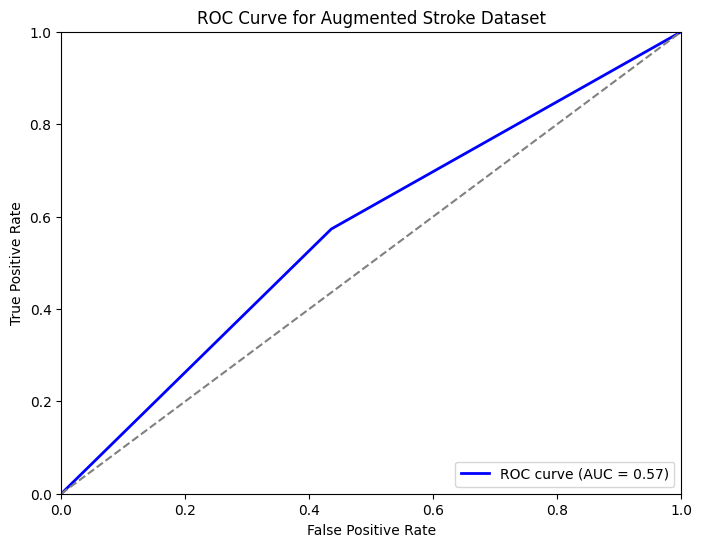

Gender Statistical Parity: -0.01017268722466963
Gender Equal Opportunity: -0.18520408163265312
Age Statistical Parity: 0.19772536177368677
Age Equal Opportunity: -0.02857142857142858


In [42]:
aug_stroke_yhat = runSVM(aug_stroke_train_X, aug_stroke_train_y, aug_stroke_test_X, 1)
aug_stroke_acc, aug_stroke_f1, aug_stroke_precision, aug_stroke_recall, aug_stroke_roc = model_evaluation(aug_stroke_test_y, aug_stroke_yhat, 'Augmented Stroke Dataset')
aug_stroke_gen_stat_par, aug_stroke_gen_eq_op = bias_evaluation(aug_stroke_yhat, aug_stroke_test_X['gender'], aug_stroke_test_y, 'Gender')
aug_stroke_age_stat_par, aug_stroke_age_eq_op = bias_evaluation(aug_stroke_yhat, aug_stroke_test_X['age'], aug_stroke_test_y, 'Age')

Accuracy score: 0.8478260869565217
F1 score: 0.8711656441717791
Confusion Matrix: 
[[ 92  20]
 [ 22 142]]
Precision: 0.8765432098765432 and Recall: 0.8658536585365854


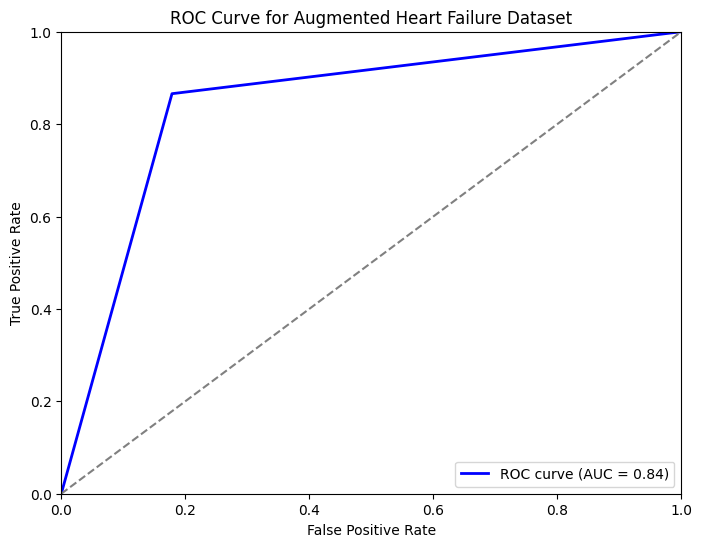

Gender Statistical Parity: 0.26086956521739135
Gender Equal Opportunity: 0.051099227569815775
Age Statistical Parity: 0.13530031612223403
Age Equal Opportunity: 0.10124634559162948


In [54]:
aug_heart_yhat = runSVM(aug_heart_train_X, aug_heart_train_y, aug_heart_test_X, 0)
aug_heart_acc, aug_heart_f1, aug_heart_precision, aug_heart_recall, aug_heart_roc = model_evaluation(aug_heart_test_y, aug_heart_yhat, 'Augmented Heart Failure Dataset')
aug_heart_gen_stat_par, aug_heart_gen_eq_op = bias_evaluation(aug_heart_yhat, aug_heart_test_X['Sex'], aug_heart_test_y, 'Gender')
aug_heart_age_stat_par, aug_heart_age_eq_op = bias_evaluation(aug_heart_yhat, aug_heart_test_X['Age'], aug_heart_test_y, 'Age')

### Case 4: SMOTE

In [17]:
smote_stroke_train = pd.read_csv('data/train_test_data/smote_stroke_train.csv')
smote_stroke_test = pd.read_csv('data/train_test_data/smote_stroke_test.csv')

smote_stroke_train_X, smote_stroke_train_y = split_Xy(smote_stroke_train, 1)
smote_stroke_test_X, smote_stroke_test_y = split_Xy(smote_stroke_test, 1)

smote_heart_train = pd.read_csv('data/train_test_data/smote_heart_train.csv')
smote_heart_test = pd.read_csv('data/train_test_data/smote_heart_test.csv')

smote_heart_train_X, smote_heart_train_y = split_Xy(smote_heart_train, 2)
smote_heart_test_X, smote_heart_test_y = split_Xy(smote_heart_test, 2)

(6832, 11) (6832,)
(1533, 11) (1533,)
(688, 11) (688,)
(276, 11) (276,)


Accuracy score: 0.731245923026745
F1 score: 0.17269076305220882
Confusion Matrix: 
[[1078  366]
 [  46   43]]
Precision: 0.10513447432762836 and Recall: 0.48314606741573035


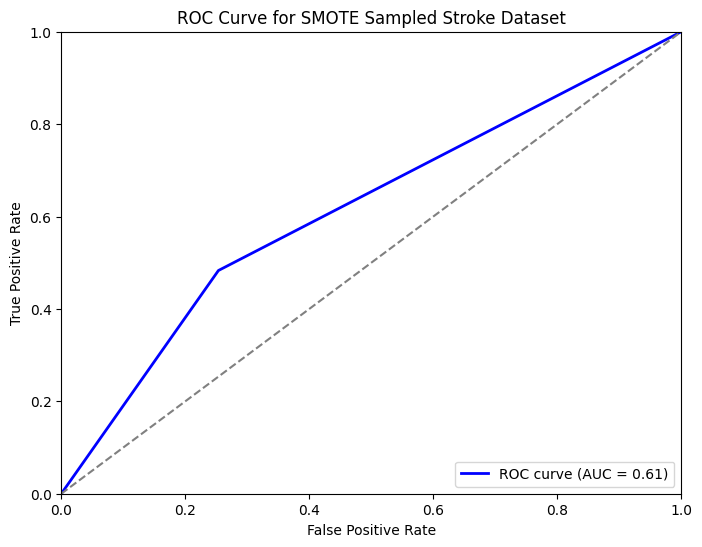

Gender Statistical Parity: 0.08442114537444936
Gender Equal Opportunity: 0.21224489795918366
Age Statistical Parity: 0.3062404471662338
Age Equal Opportunity: 0.3


In [48]:
smote_stroke_yhat = runSVM(smote_stroke_train_X, smote_stroke_train_y, smote_stroke_test_X, 0)
smote_stroke_acc, smote_stroke_f1, smote_stroke_precision, smote_stroke_recall, smote_stroke_roc = model_evaluation(smote_stroke_test_y, smote_stroke_yhat, 'SMOTE Sampled Stroke Dataset')
smote_stroke_gen_stat_par, smote_stroke_gen_eq_op = bias_evaluation(smote_stroke_yhat, smote_stroke_test_X['gender'], smote_stroke_test_y, 'Gender')
smote_stroke_age_stat_par, smote_stroke_age_eq_op = bias_evaluation(smote_stroke_yhat, smote_stroke_test_X['age'], smote_stroke_test_y, 'Age')

Accuracy score: 0.855072463768116
F1 score: 0.8757763975155279
Confusion Matrix: 
[[ 95  17]
 [ 23 141]]
Precision: 0.8924050632911392 and Recall: 0.8597560975609756


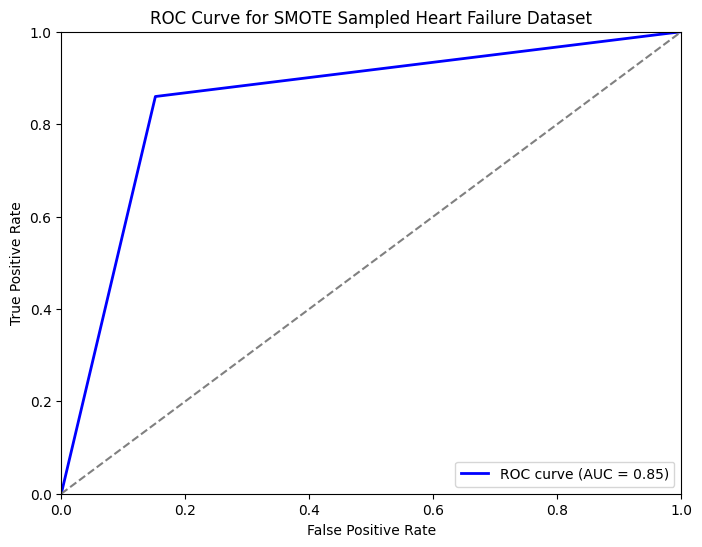

Gender Statistical Parity: 0.3739130434782609
Gender Equal Opportunity: 0.23945335710041593
Age Statistical Parity: 0.136986301369863
Age Equal Opportunity: 0.11617171872595788


In [53]:
smote_heart_yhat = runSVM(smote_heart_train_X, smote_heart_train_y, smote_heart_test_X, 0)
smote_heart_acc, smote_heart_f1, smote_heart_precision, smote_heart_recall, smote_heart_roc = model_evaluation(smote_heart_test_y, smote_heart_yhat, 'SMOTE Sampled Heart Failure Dataset')
smote_heart_gen_stat_par, smote_heart_gen_eq_op = bias_evaluation(smote_heart_yhat, smote_heart_test_X['Sex'], smote_heart_test_y, 'Gender')
smote_heart_age_stat_par, smote_heart_age_eq_op = bias_evaluation(smote_heart_yhat, smote_heart_test_X['Age'], smote_heart_test_y, 'Age')

### Case 5:

In [19]:
smote_np_stroke_train = pd.read_csv('data/train_test_data/smote_no_prot_class_stroke_train.csv')
smote_np_stroke_test = pd.read_csv('data/train_test_data/smote_no_prot_class_stroke_test.csv')

snp_stroke_train_X, snp_stroke_train_y = split_Xy(smote_np_stroke_train, 1)
snp_stroke_test_X, snp_stroke_test_y = split_Xy(smote_np_stroke_test, 1)

smote_np_heart_train = pd.read_csv('data/train_test_data/smote_no_prot_class_heart_train.csv')
smote_np_heart_test = pd.read_csv('data/train_test_data/smote_no_prot_class_heart_test.csv')

snp_heart_train_X, snp_heart_train_y = split_Xy(smote_np_heart_train, 2)
snp_heart_test_X, snp_heart_test_y = split_Xy(smote_np_heart_test, 2)

(6832, 9) (6832,)
(1533, 9) (1533,)
(688, 9) (688,)
(276, 9) (276,)


Accuracy score: 0.6979778212654925
F1 score: 0.15045871559633028
Confusion Matrix: 
[[1029  415]
 [  48   41]]
Precision: 0.08991228070175439 and Recall: 0.4606741573033708


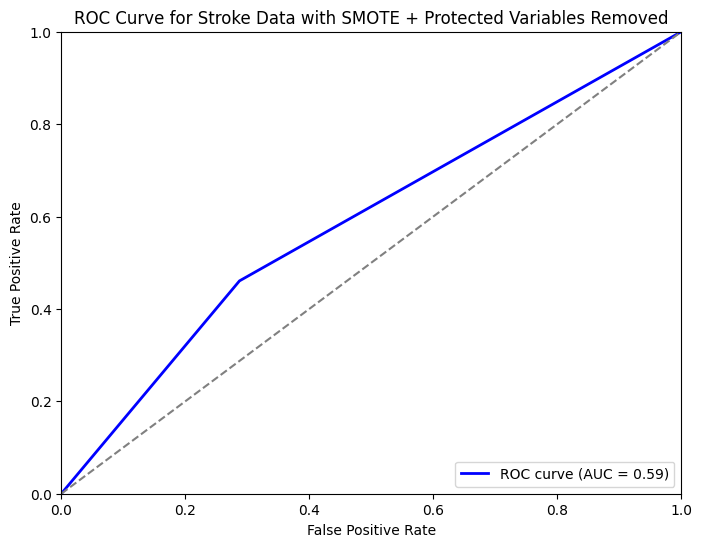

Gender Statistical Parity: 0.042977973568281924
Gender Equal Opportunity: -0.07142857142857145
Age Statistical Parity: 0.13268439309506708
Age Equal Opportunity: 0.06428571428571428


In [39]:
snp_stroke_yhat = runSVM(snp_stroke_train_X, snp_stroke_train_y, snp_stroke_test_X, 0)
snp_stroke_acc, snp_stroke_f1, snp_stroke_precision, snp_stroke_recall, snp_stroke_roc = model_evaluation(snp_stroke_test_y, snp_stroke_yhat, 'Stroke Data with SMOTE + Protected Variables Removed')
snp_stroke_gen_stat_par, snp_stroke_gen_eq_op = bias_evaluation(snp_stroke_yhat, smote_stroke_test_X['gender'], snp_stroke_test_y, 'Gender')
snp_stroke_age_stat_par, snp_stroke_age_eq_op = bias_evaluation(snp_stroke_yhat, smote_stroke_test_X['age'], snp_stroke_test_y, 'Age')

Accuracy score: 0.8442028985507246
F1 score: 0.8676923076923077
Confusion Matrix: 
[[ 92  20]
 [ 23 141]]
Precision: 0.8757763975155279 and Recall: 0.8597560975609756


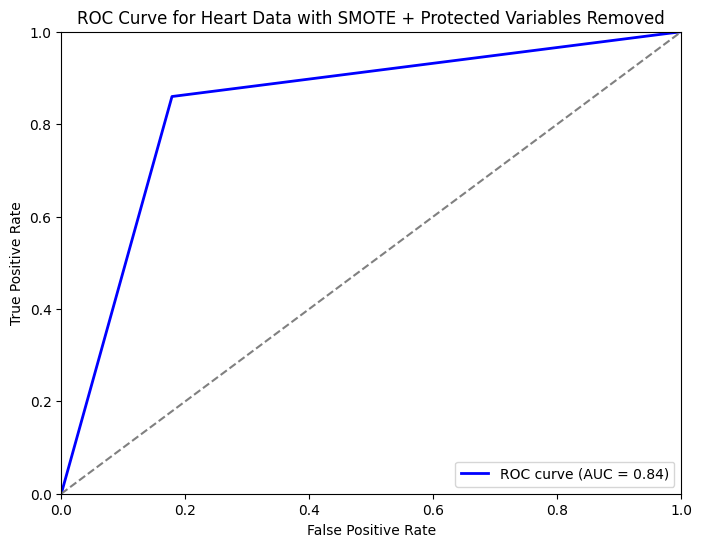

Gender Statistical Parity: 0.25652173913043486
Gender Equal Opportunity: 0.0445632798573975
Age Statistical Parity: 0.12845100105374085
Age Equal Opportunity: 0.09093706724111406


In [52]:
snp_heart_yhat = runSVM(snp_heart_train_X, snp_heart_train_y, snp_heart_test_X, 0)
snp_heart_acc, snp_heart_f1, snp_heart_precision, snp_heart_recall, snp_heart_roc = model_evaluation(snp_heart_test_y, snp_heart_yhat, 'Heart Data with SMOTE + Protected Variables Removed')
snp_heart_gen_stat_par, snp_heart_gen_eq_op = bias_evaluation(snp_heart_yhat, smote_heart_test_X['Sex'], snp_heart_test_y, 'Gender')
snp_heart_age_stat_par, snp_heart_age_eq_op = bias_evaluation(snp_heart_yhat, smote_heart_test_X['Age'], snp_heart_test_y, 'Age')

### Case 6:

In [21]:
saug_stroke_train = pd.read_csv('data/train_test_data/smote_stroke_augmented_data_train.csv')
saug_stroke_test = pd.read_csv('data/train_test_data/smote_stroke_augmented_data_test.csv')

saug_stroke_train_X, saug_stroke_train_y = split_Xy(saug_stroke_train, 1)
saug_stroke_test_X, saug_stroke_test_y = split_Xy(saug_stroke_test, 1)

saug_heart_train = pd.read_csv('data/train_test_data/smote_heart_augmented_data_train.csv')
saug_heart_test = pd.read_csv('data/train_test_data/smote_heart_augmented_data_test.csv')

saug_heart_train_X, saug_heart_train_y = split_Xy(saug_heart_train, 2)
saug_heart_test_X, saug_heart_test_y = split_Xy(saug_heart_test, 2)

(13664, 11) (13664,)
(1533, 11) (1533,)
(1330, 11) (1330,)
(276, 11) (276,)


Accuracy score: 0.7077625570776256
F1 score: 0.15151515151515152
Confusion Matrix: 
[[1045  399]
 [  49   40]]
Precision: 0.09111617312072894 and Recall: 0.449438202247191


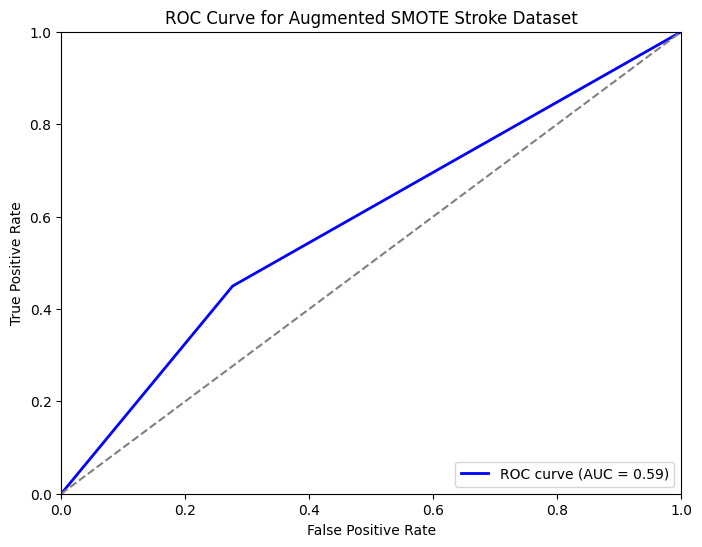

Gender Statistical Parity: 0.04046343612334802
Gender Equal Opportunity: -0.04642857142857143
Age Statistical Parity: 0.12878496464813233
Age Equal Opportunity: 0.05238095238095236


In [40]:
saug_stroke_yhat = runSVM(saug_stroke_train_X, saug_stroke_train_y, saug_stroke_test_X, 0)
saug_stroke_acc, saug_stroke_f1, saug_stroke_precision, saug_stroke_recall, saug_stroke_roc = model_evaluation(saug_stroke_test_y, saug_stroke_yhat, 'Augmented SMOTE Stroke Dataset')
saug_stroke_gen_stat_par, saug_stroke_gen_eq_op = bias_evaluation(saug_stroke_yhat, saug_stroke_test_X['gender'], saug_stroke_test_y, 'Gender')
saug_stroke_age_stat_par, saug_stroke_age_eq_op = bias_evaluation(saug_stroke_yhat, saug_stroke_test_X['age'], saug_stroke_test_y, 'Age')

Accuracy score: 0.8442028985507246
F1 score: 0.8676923076923077
Confusion Matrix: 
[[ 92  20]
 [ 23 141]]
Precision: 0.8757763975155279 and Recall: 0.8597560975609756


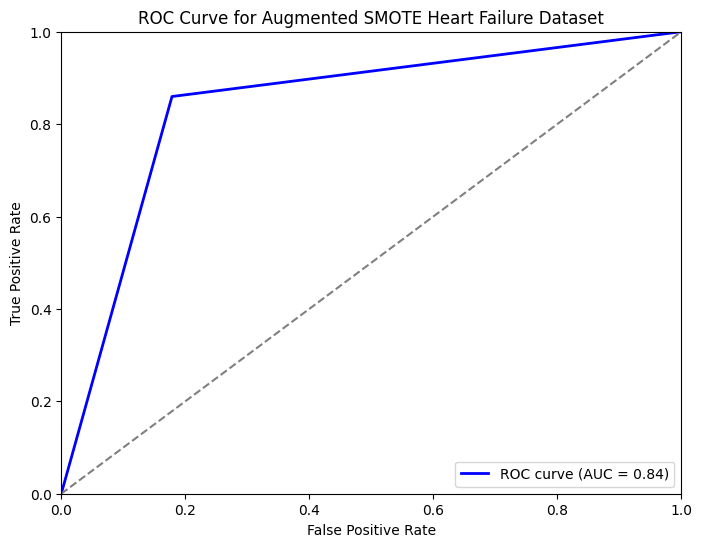

Gender Statistical Parity: 0.25652173913043486
Gender Equal Opportunity: 0.0445632798573975
Age Statistical Parity: 0.12845100105374085
Age Equal Opportunity: 0.09093706724111406


In [51]:
saug_heart_yhat = runSVM(saug_heart_train_X, saug_heart_train_y, saug_heart_test_X, 0)
saug_heart_acc, saug_heart_f1, saug_heart_precision, saug_heart_recall, saug_heart_roc = model_evaluation(saug_heart_test_y, saug_heart_yhat, 'Augmented SMOTE Heart Failure Dataset')
saug_heart_gen_stat_par, saug_heart_gen_eq_op = bias_evaluation(saug_heart_yhat, saug_heart_test_X['Sex'], saug_heart_test_y, 'Gender')
saug_heart_age_stat_par, saug_heart_age_eq_op = bias_evaluation(saug_heart_yhat, saug_heart_test_X['Age'], saug_heart_test_y, 'Age')

### Result Summary

In [57]:
eval_summary = {
    'Base_Stroke': [base_stroke_acc, base_stroke_f1, base_stroke_precision, base_stroke_recall, base_stroke_roc, abs(base_stroke_gen_stat_par), abs(base_stroke_gen_eq_op), abs(base_stroke_age_stat_par), abs(base_stroke_age_eq_op)],
    'Removed_Prot_Stroke': [np_stroke_acc, np_stroke_f1, np_stroke_precision, np_stroke_recall, np_stroke_roc, abs(np_stroke_gen_stat_par), abs(np_stroke_gen_eq_op), abs(np_stroke_age_stat_par), abs(np_stroke_age_eq_op)],
    'Augmented_Stroke': [aug_stroke_acc, aug_stroke_f1, aug_stroke_precision, aug_stroke_recall, aug_stroke_roc, abs(aug_stroke_gen_stat_par), abs(aug_stroke_gen_eq_op), abs(aug_stroke_age_stat_par), abs(aug_stroke_age_eq_op)],
    'SMOTE_Stroke': [smote_stroke_acc, smote_stroke_f1, smote_stroke_precision, smote_stroke_recall, smote_stroke_roc, abs(smote_stroke_gen_stat_par), abs(smote_stroke_gen_eq_op), abs(smote_stroke_age_stat_par), abs(smote_stroke_age_eq_op)],
    'SMOTE_RmProt_Stroke': [snp_stroke_acc, snp_stroke_f1, snp_stroke_precision, snp_stroke_recall, snp_stroke_roc, abs(snp_stroke_gen_stat_par), abs(snp_stroke_gen_eq_op), abs(snp_stroke_age_stat_par), abs(snp_stroke_age_eq_op)],
    'SMOTE_Aug_Stroke': [saug_stroke_acc, saug_stroke_f1, saug_stroke_precision, saug_stroke_recall, saug_stroke_roc, abs(saug_stroke_gen_stat_par), abs(saug_stroke_gen_eq_op), abs(saug_stroke_age_stat_par), abs(saug_stroke_age_eq_op)],
    'Base_Heart_Failure': [base_heart_acc, base_heart_f1, base_heart_precision, base_heart_recall, base_heart_roc, abs(base_heart_gen_stat_par), abs(base_heart_gen_eq_op), abs(base_heart_age_stat_par), abs(base_heart_age_eq_op)],
    'Removed_Prot_Heart_Failure': [np_heart_acc, np_heart_f1, np_heart_precision, np_heart_recall, np_heart_roc, abs(np_heart_gen_stat_par), abs(np_heart_gen_eq_op), abs(np_heart_age_stat_par), abs(np_heart_age_eq_op)],
    'Augmented_Heart_Failure': [aug_heart_acc, aug_heart_f1, aug_heart_precision, aug_heart_recall, aug_heart_roc, abs(aug_heart_gen_stat_par), abs(aug_heart_gen_eq_op), abs(aug_heart_age_stat_par), abs(aug_heart_age_eq_op)],
    'SMOTE_Heart_Failure': [smote_heart_acc, smote_heart_f1, smote_heart_precision, smote_heart_recall, smote_heart_roc, abs(smote_heart_gen_stat_par), abs(smote_heart_gen_eq_op), abs(smote_heart_age_stat_par), abs(smote_heart_age_eq_op)],
    'SMOTE_RmProt_Heart': [snp_heart_acc, snp_heart_f1, snp_heart_precision, snp_heart_recall, snp_heart_roc, abs(snp_heart_gen_stat_par), abs(snp_heart_gen_eq_op), abs(snp_heart_age_stat_par), abs(snp_heart_age_eq_op)],
    'SMOTE_Aug_Heart': [saug_heart_acc, saug_heart_f1, saug_heart_precision, saug_heart_recall, saug_heart_roc, abs(saug_heart_gen_stat_par), abs(saug_heart_gen_eq_op), abs(saug_heart_age_stat_par), abs(saug_heart_age_eq_op)]
    }

summary = pd.DataFrame.from_dict(eval_summary, orient='index', columns=['Accuracy', 'F1_score', 'Precision', 'Recall', 'ROC_score', 'Gender_Stat_Parity', 'Gender_Equal_Opp', 'Age_Stat_Parity', 'Age_Equal_Opp'])
summary

,Accuracy,F1_score,Precision,Recall,ROC_score,Gender_Stat_Parity,Gender_Equal_Opp,Age_Stat_Parity,Age_Equal_Opp
Base_Stroke,0.511416,0.147895,0.082278,0.730337,0.614130,0.038037,0.126531,0.445512,0.350000
Removed_Prot_Stroke,0.487280,0.122768,0.068154,0.617978,0.548601,0.021642,0.148980,0.183266,0.019048
Augmented_Stroke,0.564905,0.132640,0.075000,0.573034,0.568719,0.010173,0.185204,0.197725,0.028571
SMOTE_Stroke,0.731246,0.172691,0.105134,0.483146,0.614842,0.084421,0.212245,0.306240,0.300000
SMOTE_RmProt_Stroke,0.697978,0.150459,0.089912,0.460674,0.586639,0.042978,0.071429,0.132684,0.064286
SMOTE_Aug_Stroke,0.707763,0.151515,0.091116,0.449438,0.586561,0.040463,0.046429,0.128785,0.052381
Base_Heart_Failure,0.858696,0.879257,0.893082,0.865854,0.857034,0.378261,0.245989,0.158377,0.151716
Removed_Prot_Heart_Failure,0.851449,0.873846,0.881988,0.865854,0.848105,0.256522,0.051099,0.142993,0.101246
Augmented_Heart_Failure,0.847826,0.871166,0.876543,0.865854,0.843641,0.260870,0.051099,0.135300,0.101246
SMOTE_Heart_Failure,0.855072,0.875776,0.892405,0.859756,0.853985,0.373913,0.239453,0.136986,0.116172


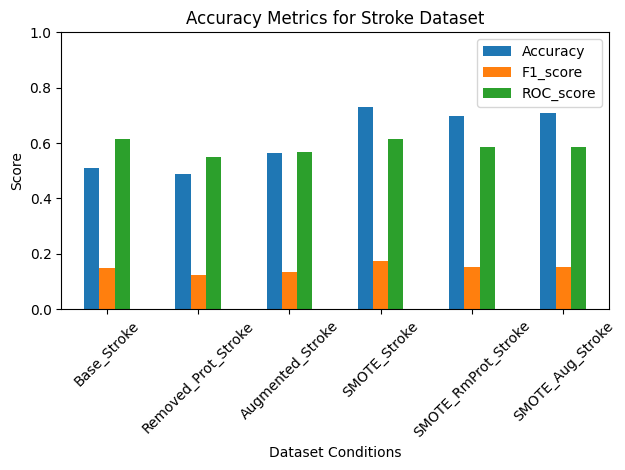

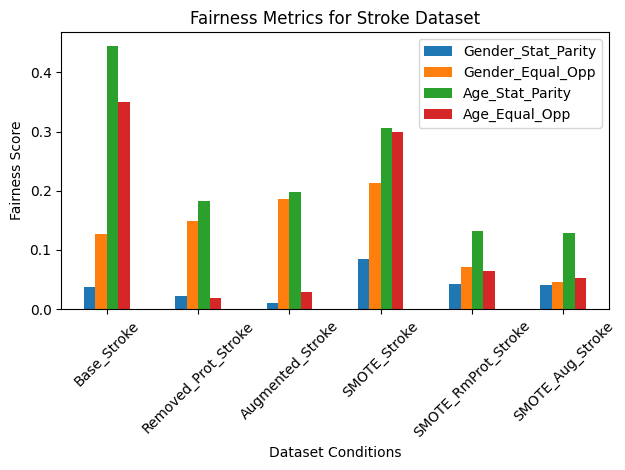

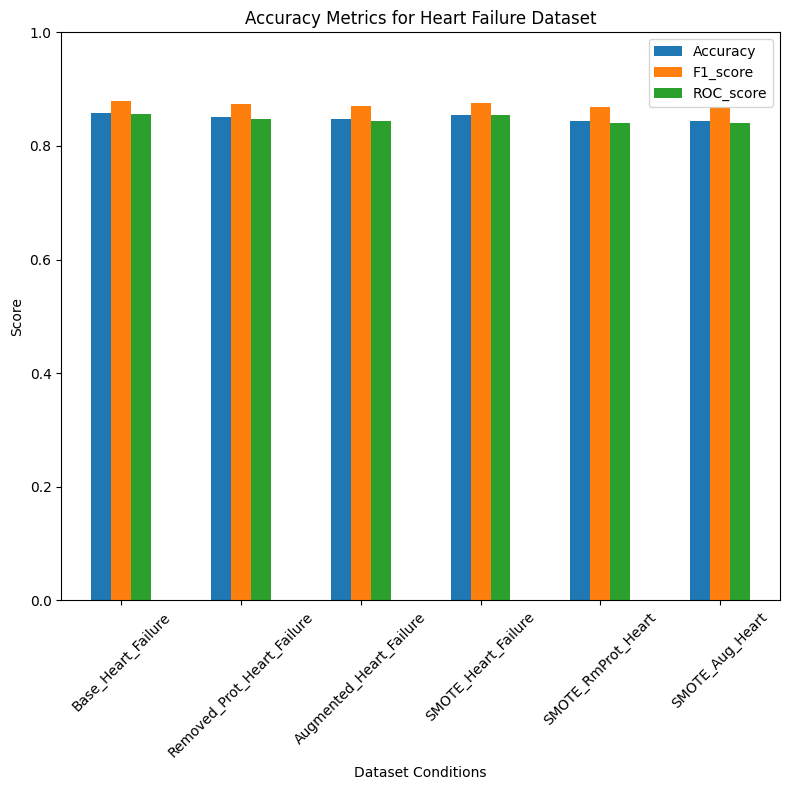

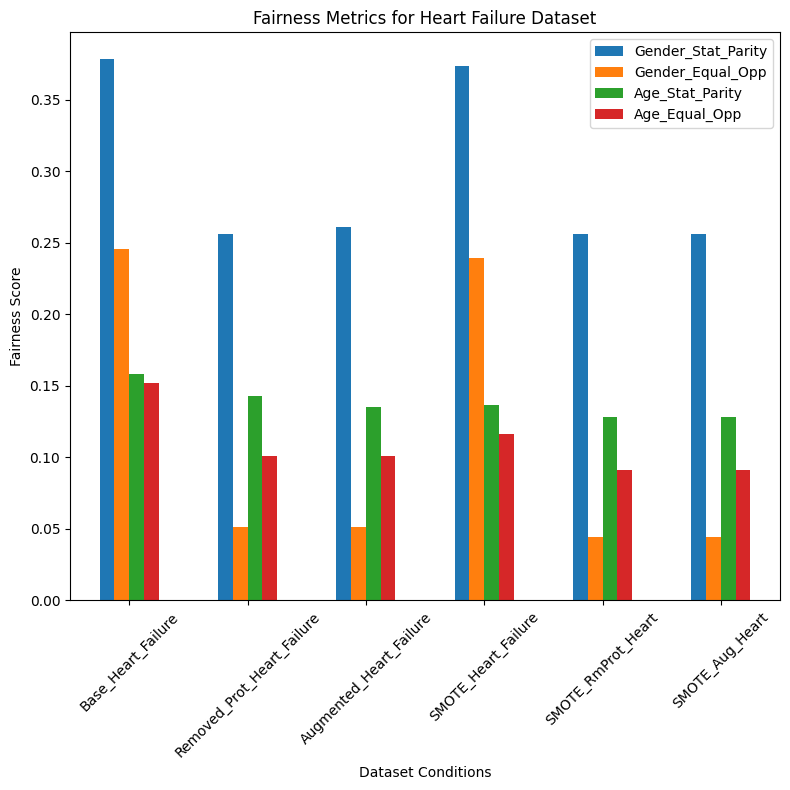

In [61]:
stroke_eval = summary.iloc[:6]
heart_eval = summary.iloc[6:]

sns.set_theme(style="darkgrid")
colors = sns.color_palette('Set2')

# Plotting stroke acc evals
stroke_eval[['Accuracy', 'F1_score', 'ROC_score']].plot(kind='bar', figsize=(12, 12), color=colors)
plt.title('Accuracy Metrics for Stroke Dataset', fontsize=16)
plt.xlabel('Dataset Conditions', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()

# Plotting stroke fairness evals
stroke_eval[['Gender_Stat_Parity', 'Gender_Equal_Opp', 'Age_Stat_Parity', 'Age_Equal_Opp']].plot(kind='bar', figsize=(12, 12), color=colors)
plt.title('Fairness Metrics for Stroke Dataset', fontsize=16)
plt.xlabel('Dataset Conditions', fontsize=16)
plt.ylabel('Fairness Disparity', fontsize=16)
plt.xticks(rotation=45)
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()

# Plotting heart failure evals
heart_eval[['Accuracy', 'F1_score', 'ROC_score']].plot(kind='bar', figsize=(12, 12), color=colors)
plt.title('Accuracy Metrics for Heart Failure Dataset', fontsize=16)
plt.xlabel('Dataset Conditions', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()

# Plotting heart failure evals
heart_eval[['Gender_Stat_Parity', 'Gender_Equal_Opp', 'Age_Stat_Parity', 'Age_Equal_Opp']].plot(kind='bar', figsize=(12, 12), color=colors)
plt.title('Fairness Metrics for Heart Failure Dataset', fontsize=16)
plt.xlabel('Dataset Conditions', fontsize=16)
plt.ylabel('Fairness Disparity', fontsize=16)
plt.xticks(rotation=45)
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()